# Symmetry Regularization Results Visualization

This notebook visualizes learned dynamics from all experiments:
- **regularizer_comparison**: Different symmetry types (rotation, translation) at various lambda values
- **consensus**: Consensus dynamics with rotation symmetry
- **multi_animal**: Multi-animal shared dynamics
- **sphere_so3**: 3D SO(3) symmetry on sphere

In [21]:
# Setup - Use absolute paths to avoid import issues
import sys
from pathlib import Path

# Project root (works regardless of where jupyter is started)
PROJECT_ROOT = Path('/orcd/data/manoli/001/om2/artliang/symm_reg')
sys.path.insert(0, str(PROJECT_ROOT))
sys.path.insert(0, str(PROJECT_ROOT / 'in_progress'))

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import glob
import warnings
warnings.filterwarnings('ignore')

import xfads.utils as utils
import xfads.plot_utils as plot_utils
from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.likelihoods import GaussianLikelihood
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.smoothers.nonlinear_smoother import NonlinearFilterSmallL

from regularized_ssm import RegularizedSSM, RegularizedLightningSSM
from test_dynamics import PerturbedRingAttractorRNN

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150

RESULTS_DIR = PROJECT_ROOT / 'results'
FIGURES_DIR = RESULTS_DIR / 'figures'
FIGURES_DIR.mkdir(exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
print(f"Results directory: {RESULTS_DIR}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cuda
Results directory: /orcd/data/manoli/001/om2/artliang/symm_reg/results


## 1. Utility Functions

In [22]:
def get_completed_runs(experiment_name):
    """Get list of completed runs (those with checkpoints)."""
    exp_dir = RESULTS_DIR / experiment_name
    if not exp_dir.exists():
        return []
    ckpt_dirs = list(exp_dir.glob('*/ckpts/*.ckpt'))
    return sorted(set(p.parent.parent.name for p in ckpt_dirs))


def load_sweep_csv(experiment_name):
    """Load summary CSV if sweep is complete."""
    for name in ['sweep_results.csv', 'consensus_results.csv', 'multi_animal_results.csv']:
        path = RESULTS_DIR / experiment_name / name
        if path.exists():
            return pd.read_csv(path)
    return None


def load_metrics_csv(experiment_name, run_name):
    """Load training metrics for a specific run."""
    path = RESULTS_DIR / experiment_name / run_name / 'logs' / 'metrics.csv'
    if path.exists():
        return pd.read_csv(path)
    return None


print("=== Experiment Status ===")
for exp in ['regularizer_comparison', 'consensus', 'multi_animal', 'sphere_so3']:
    runs = get_completed_runs(exp)
    df = load_sweep_csv(exp)
    status = f"COMPLETE ({len(df)} runs)" if df is not None else f"{len(runs)} runs done"
    print(f"  {exp}: {status}")

=== Experiment Status ===
  regularizer_comparison: 22 runs done
  consensus: COMPLETE (5 runs)
  multi_animal: COMPLETE (4 runs)
  sphere_so3: COMPLETE (4 runs)


In [23]:
def load_trained_model(experiment_name, run_name, n_latents=None):
    """
    Load a trained model from checkpoint.
    Returns the RegularizedSSM and config.
    """
    run_dir = RESULTS_DIR / experiment_name / run_name
    ckpt_files = list((run_dir / 'ckpts').glob('*.ckpt'))
    if not ckpt_files:
        raise FileNotFoundError(f"No checkpoint found in {run_dir / 'ckpts'}")
    
    ckpt_path = ckpt_files[0]
    ckpt = torch.load(ckpt_path, map_location='cpu', weights_only=False)
    state_dict = ckpt['state_dict']
    
    # Infer latent dimensions from experiment type
    if n_latents is None:
        n_latents = 3 if 'sphere' in experiment_name else 2
    
    n_neurons = 100
    n_hidden_dynamics = 128 if n_latents == 3 else 64
    n_hidden_local = 128
    n_hidden_backward = 64
    rank_local = n_latents
    rank_backward = n_latents
    
    # Create model components
    Q_diag = 5e-3 * torch.ones(n_latents)
    Q_0_diag = 1.0 * torch.ones(n_latents)
    R_diag = 1e-1 * torch.ones(n_neurons)
    m_0 = torch.zeros(n_latents)
    
    C = utils.FanInLinear(n_latents, n_neurons, device='cpu')
    H = utils.ReadoutLatentMask(n_latents, n_latents)
    readout_fn = nn.Sequential(H, C)
    likelihood_pdf = GaussianLikelihood(readout_fn, n_neurons, R_diag, device='cpu', fix_R=True)
    
    dynamics_fn = utils.build_gru_dynamics_function(n_latents, n_hidden_dynamics, device='cpu')
    dynamics_mod = DenseGaussianDynamics(dynamics_fn, n_latents, Q_diag, device='cpu')
    initial_condition_pdf = DenseGaussianInitialCondition(n_latents, m_0, Q_0_diag, device='cpu')
    
    backward_encoder = BackwardEncoderLRMvn(
        n_latents, n_hidden_backward, n_latents,
        rank_local=rank_local, rank_backward=rank_backward, device='cpu'
    )
    local_encoder = LocalEncoderLRMvn(
        n_latents, n_neurons, n_hidden_local, n_latents,
        rank=rank_local, device='cpu', dropout=0.4
    )
    nl_filter = NonlinearFilterSmallL(dynamics_mod, initial_condition_pdf, device='cpu')
    
    ssm = RegularizedSSM(
        dynamics_mod=dynamics_mod,
        likelihood_pdf=likelihood_pdf,
        initial_c_pdf=initial_condition_pdf,
        backward_encoder=backward_encoder,
        local_encoder=local_encoder,
        nl_filter=nl_filter,
        target_vector_field=lambda x: torch.zeros_like(x),
        lambda_lie=0.0,
        lambda_curvature=0.0,
        device='cpu'
    )
    
    # Load weights
    ssm_state = {k.replace('ssm.', ''): v for k, v in state_dict.items() if k.startswith('ssm.')}
    ssm.load_state_dict(ssm_state, strict=False)
    ssm.eval()
    
    return ssm, {'n_latents': n_latents, 'run_name': run_name, 'ckpt_path': str(ckpt_path)}

## 2. Visualization Functions

In [47]:
def plot_2d_dynamics(ssm, title="Learned Dynamics", ax=None, n_latents=2, 
                     n_trials=15, n_time=50, show_trajectories=True):
    """Plot 2D vector field and sample trajectories."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    dynamics_fn = ssm.dynamics_mod.mean_fn
    plot_utils.plot_two_d_vector_field(dynamics_fn, ax, min_xy=-2, max_xy=2)
    
    if show_trajectories:
        z_0 = torch.zeros((1, n_trials, n_latents))
        z_0[:, ::2] = 0.3 * torch.randn_like(z_0[:, ::2])
        z_0[:, 1::2] = 1.5 * torch.randn_like(z_0[:, 1::2])
        
        with torch.no_grad():
            z_traj = ssm.predict_forward(z_0, n_time)
        
        for i in range(n_trials):
            ax.plot(z_traj[0, i, :, 0], z_traj[0, i, :, 1], 'b-', alpha=0.5, linewidth=1)
            ax.plot(z_traj[0, i, 0, 0], z_traj[0, i, 0, 1], 'go', markersize=4)
            ax.plot(z_traj[0, i, -1, 0], z_traj[0, i, -1, 1], 'ro', markersize=4)
    
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    ax.set_title(title, fontweight='bold', fontsize=10)
    ax.set_xlabel('Latent dim 1')
    ax.set_ylabel('Latent dim 2')
    
    return ax


def plot_3d_dynamics(ssm, title="3D Dynamics", ax=None, n_trials=20, n_time=100):
    """Plot 3D trajectories on sphere for SO(3) experiments."""
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
    
    # Generate trajectories starting on unit sphere
    z_0 = torch.randn((1, n_trials, 3))
    z_0 = z_0 / z_0.norm(dim=-1, keepdim=True)  # Project to unit sphere
    
    with torch.no_grad():
        z_traj = ssm.predict_forward(z_0, n_time)
    
    # Plot unit sphere wireframe
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 20)
    x_sphere = np.outer(np.cos(u), np.sin(v))
    y_sphere = np.outer(np.sin(u), np.sin(v))
    z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(x_sphere, y_sphere, z_sphere, alpha=0.1, color='gray')
    
    # Plot trajectories
    colors = plt.cm.viridis(np.linspace(0, 1, n_trials))
    for i in range(n_trials):
        traj = z_traj[0, i].numpy()
        ax.plot3D(traj[:, 0], traj[:, 1], traj[:, 2], '-', color=colors[i], alpha=0.7, linewidth=1)
        ax.scatter(traj[0, 0], traj[0, 1], traj[0, 2], c='green', s=20, marker='o')
        ax.scatter(traj[-1, 0], traj[-1, 1], traj[-1, 2], c='red', s=20, marker='o')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title, fontweight='bold')
    ax.set_box_aspect([1, 1, 1])
    
    return ax


def plot_3d_vector_field(ssm, ax=None, n_pts=8):
    """Plot 3D vector field on sphere surface."""
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
    
    dynamics_fn = ssm.dynamics_mod.mean_fn
    
    # Generate points on sphere
    phi = np.linspace(0, np.pi, n_pts)
    theta = np.linspace(0, 2*np.pi, n_pts*2)
    phi, theta = np.meshgrid(phi, theta)
    
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    
    points = torch.tensor(np.stack([x.flatten(), y.flatten(), z.flatten()], axis=1), dtype=torch.float32)
    
    with torch.no_grad():
        velocities = dynamics_fn(points) - points
    
    # Plot sphere
    ax.plot_surface(x, y, z, alpha=0.1, color='lightblue')
    
    # Plot vectors
    # scale = 0.3
    # ax.quiver(points[:, 0], points[:, 1], points[:, 2],
    #           velocities[:, 0]*scale, velocities[:, 1]*scale, velocities[:, 2]*scale,
    #           color='red', alpha=0.6, arrow_length_ratio=0.3)
    
    # Normalize velocities for visibility, color by magnitude
    vel_mag = torch.norm(velocities, dim=1)
    vel_normalized = velocities / (vel_mag.unsqueeze(1) + 1e-6)  # unit vectors

    # Scale for display
    scale = 0.15

    # Plot vectors with color mapped to magnitude
    colors = plt.cm.plasma(vel_mag.numpy() / vel_mag.max().numpy())
    q = ax.quiver(points[:, 0], points[:, 1], points[:, 2],
                vel_normalized[:, 0]*scale, vel_normalized[:, 1]*scale, vel_normalized[:, 2]*scale,
                colors=colors, alpha=0.9, arrow_length_ratio=0.4, linewidth=1.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect([1, 1, 1])
    
    return ax

## 3. Ground Truth Dynamics

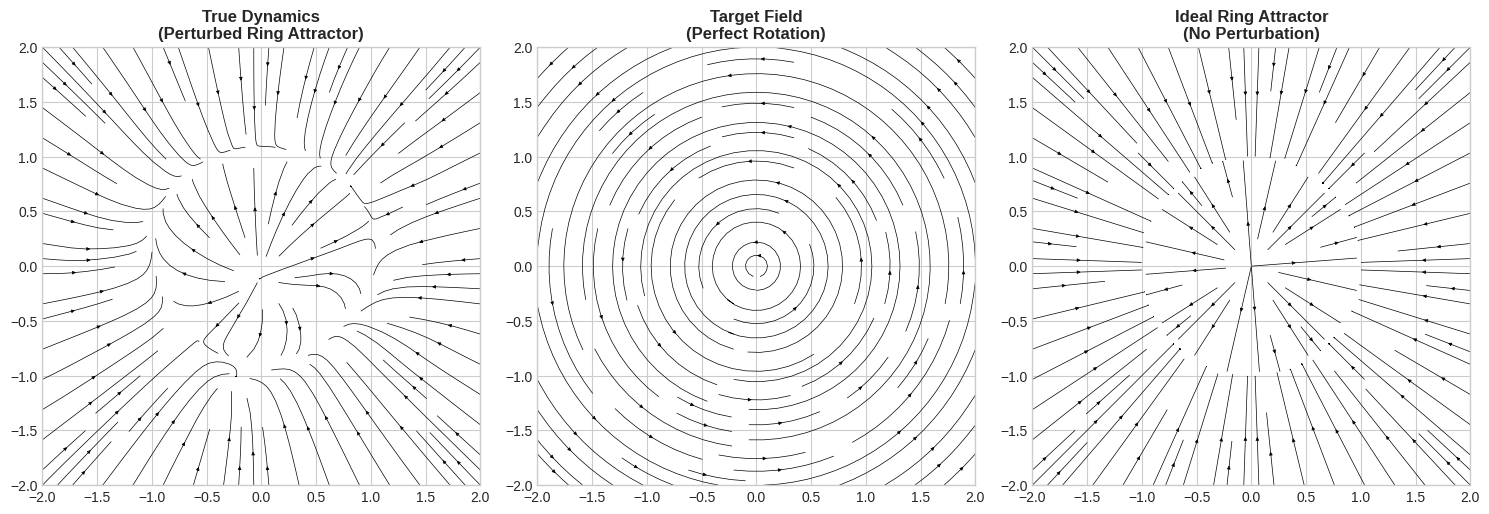

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# True perturbed dynamics
true_dynamics = PerturbedRingAttractorRNN(bin_sz=0.1, lengthscale=0.2, perturbation_magnitude=0.1)
plot_utils.plot_two_d_vector_field(true_dynamics, axes[0], min_xy=-2, max_xy=2)
axes[0].set_title('True Dynamics\n(Perturbed Ring Attractor)', fontweight='bold')
axes[0].set_xlim(-2, 2)
axes[0].set_ylim(-2, 2)
axes[0].set_aspect('equal')

# Perfect rotation field
def rotation_field(x):
    return 0.5 * torch.stack([-x[..., 1], x[..., 0]], dim=-1)

dt = 0.1
plot_utils.plot_two_d_vector_field(lambda x: x + dt * rotation_field(x), axes[1], min_xy=-2, max_xy=2)
axes[1].set_title('Target Field\n(Perfect Rotation)', fontweight='bold')
axes[1].set_xlim(-2, 2)
axes[1].set_ylim(-2, 2)
axes[1].set_aspect('equal')

# Perfect ring attractor (no perturbation)
ring_dynamics = PerturbedRingAttractorRNN(bin_sz=0.1, perturbation_magnitude=0)
plot_utils.plot_two_d_vector_field(ring_dynamics, axes[2], min_xy=-2, max_xy=2)
axes[2].set_title('Ideal Ring Attractor\n(No Perturbation)', fontweight='bold')
axes[2].set_xlim(-2, 2)
axes[2].set_ylim(-2, 2)
axes[2].set_aspect('equal')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'ground_truth_dynamics.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Regularizer Comparison Experiment

Compare learned dynamics across different symmetry types and lambda values.

In [26]:
experiment = 'regularizer_comparison'
completed_runs = get_completed_runs(experiment)
print(f"Completed runs: {len(completed_runs)}")

# Group by symmetry type
symmetry_groups = {}
for run in completed_runs:
    # Extract symmetry type (e.g., 'lie_rotation', 'lie_translation_x')
    parts = run.rsplit('_lambda_', 1)
    if len(parts) == 2:
        sym_type = parts[0]
        if sym_type not in symmetry_groups:
            symmetry_groups[sym_type] = []
        symmetry_groups[sym_type].append(run)

print(f"\nSymmetry types: {list(symmetry_groups.keys())}")
for sym, runs in symmetry_groups.items():
    print(f"  {sym}: {len(runs)} runs")

Completed runs: 22

Symmetry types: ['lie_rotation', 'lie_translation_diag', 'lie_translation_x', 'lie_translation_y', 'rotation_invariance']
  lie_rotation: 5 runs
  lie_translation_diag: 5 runs
  lie_translation_x: 5 runs
  lie_translation_y: 5 runs
  rotation_invariance: 2 runs


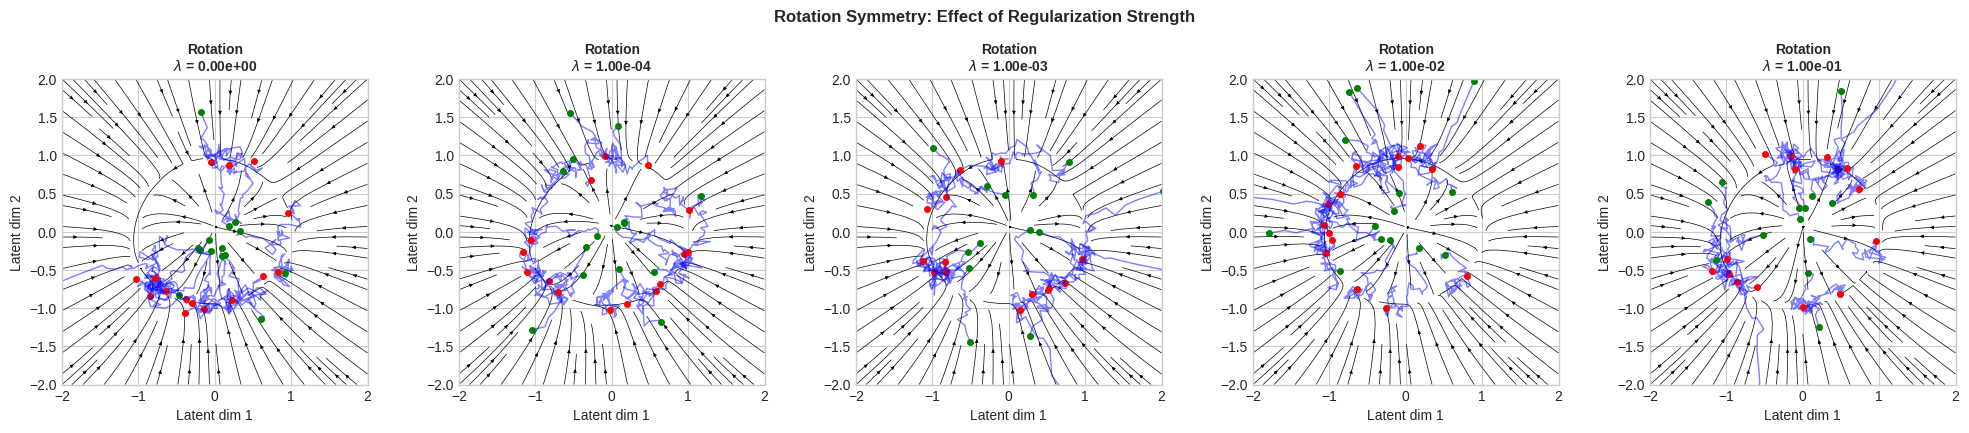

In [27]:
# Visualize rotation symmetry across lambda values
rotation_runs = symmetry_groups.get('lie_rotation', [])
rotation_runs = sorted(rotation_runs, key=lambda x: float(x.split('lambda_')[-1]))

if rotation_runs:
    n_plots = min(5, len(rotation_runs))
    fig, axes = plt.subplots(1, n_plots, figsize=(4*n_plots, 4))
    if n_plots == 1:
        axes = [axes]
    
    for ax, run_name in zip(axes, rotation_runs[:n_plots]):
        try:
            ssm, cfg = load_trained_model(experiment, run_name)
            lambda_str = run_name.split('lambda_')[-1]
            plot_2d_dynamics(ssm, title=f"Rotation\n$\\lambda$ = {lambda_str}", ax=ax)
        except Exception as e:
            ax.text(0.5, 0.5, f"Error:\n{str(e)[:50]}", ha='center', va='center', 
                    transform=ax.transAxes, fontsize=8)
            ax.set_title(run_name[-30:])
    
    plt.suptitle('Rotation Symmetry: Effect of Regularization Strength', fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'rotation_lambda_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No rotation runs found")

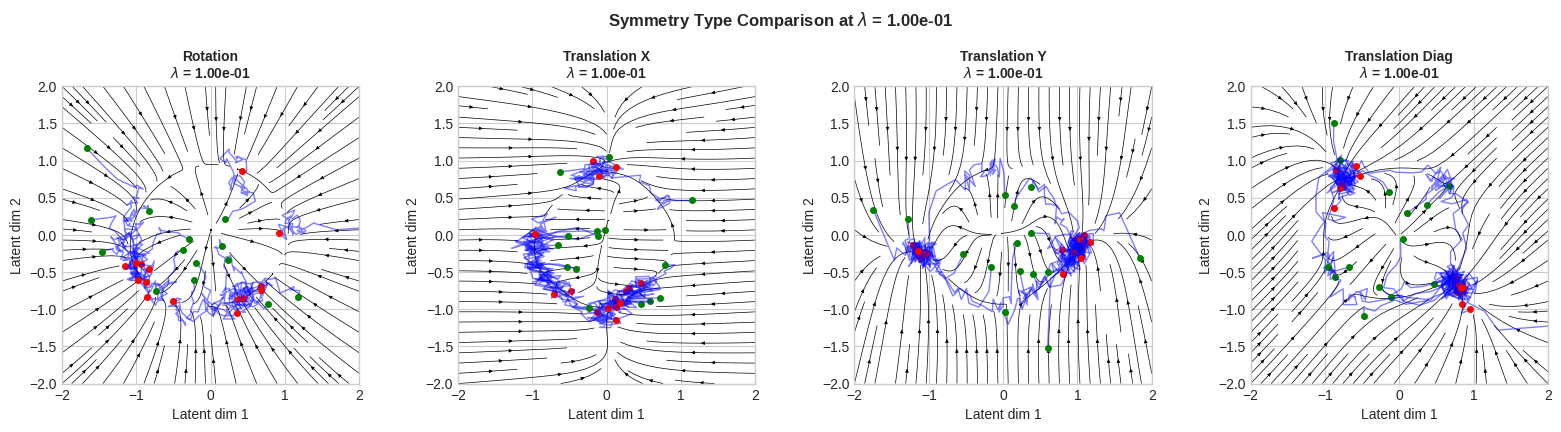

In [29]:
# Compare different symmetry types at same lambda
target_lambda = '1.00e-01' 

symmetry_types = ['lie_rotation', 'lie_translation_x', 'lie_translation_y', 'lie_translation_diag']
available_types = [s for s in symmetry_types if s in symmetry_groups]

if available_types:
    fig, axes = plt.subplots(1, len(available_types), figsize=(4*len(available_types), 4))
    if len(available_types) == 1:
        axes = [axes]
    
    for ax, sym_type in zip(axes, available_types):
        run_name = f"{sym_type}_lambda_{target_lambda}"
        try:
            ssm, cfg = load_trained_model(experiment, run_name)
            title = sym_type.replace('lie_', '').replace('_', ' ').title()
            plot_2d_dynamics(ssm, title=f"{title}\n$\\lambda$ = {target_lambda}", ax=ax)
        except Exception as e:
            ax.text(0.5, 0.5, f"Not found", ha='center', va='center', transform=ax.transAxes)
            ax.set_title(sym_type)
    
    plt.suptitle(f'Symmetry Type Comparison at $\\lambda$ = {target_lambda}', fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'symmetry_type_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

## 5. Consensus Experiment

Consensus dynamics with rotation symmetry regularization.

Consensus runs: ['consensus_lie_rotation_lambda_0.00e+00', 'consensus_lie_rotation_lambda_1.00e-04', 'consensus_lie_rotation_lambda_1.00e-03', 'consensus_lie_rotation_lambda_1.00e-02', 'consensus_lie_rotation_lambda_1.00e-01']


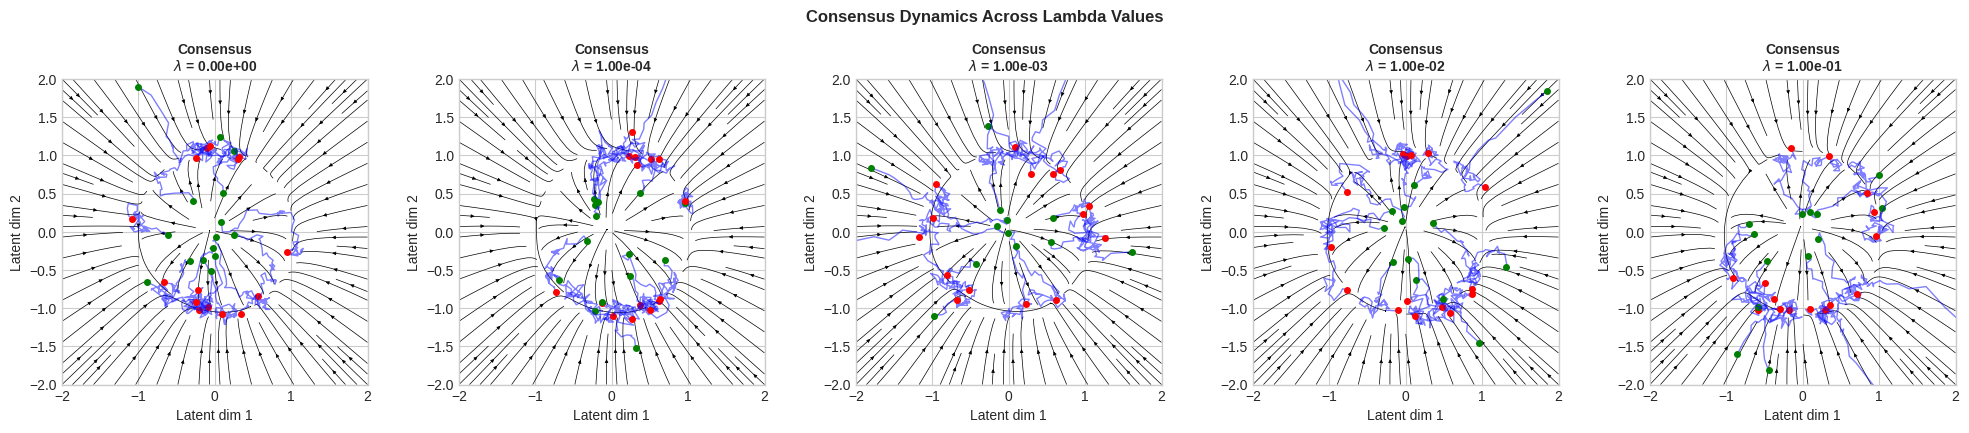

In [30]:
experiment = 'consensus'
consensus_runs = get_completed_runs(experiment)
consensus_runs = sorted(consensus_runs, key=lambda x: float(x.split('lambda_')[-1]) if 'lambda_' in x else 0)

print(f"Consensus runs: {consensus_runs}")

if consensus_runs:
    n_plots = min(5, len(consensus_runs))
    fig, axes = plt.subplots(1, n_plots, figsize=(4*n_plots, 4))
    if n_plots == 1:
        axes = [axes]
    
    for ax, run_name in zip(axes, consensus_runs[:n_plots]):
        try:
            ssm, cfg = load_trained_model(experiment, run_name)
            lambda_str = run_name.split('lambda_')[-1] if 'lambda_' in run_name else '?'
            plot_2d_dynamics(ssm, title=f"Consensus\n$\\lambda$ = {lambda_str}", ax=ax)
        except Exception as e:
            ax.text(0.5, 0.5, f"Error: {str(e)[:30]}", ha='center', va='center', 
                    transform=ax.transAxes, fontsize=8)
    
    plt.suptitle('Consensus Dynamics Across Lambda Values', fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'consensus_dynamics.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No consensus runs found")

## 6. Multi-Animal Experiment

Shared dynamics across multiple animals with rotation symmetry.

Multi-animal runs: ['multi_shared_lie_rotation_lambda_0.00e+00', 'multi_shared_lie_rotation_lambda_1.00e-04', 'multi_shared_lie_rotation_lambda_1.00e-03', 'multi_shared_lie_rotation_lambda_1.00e-02']


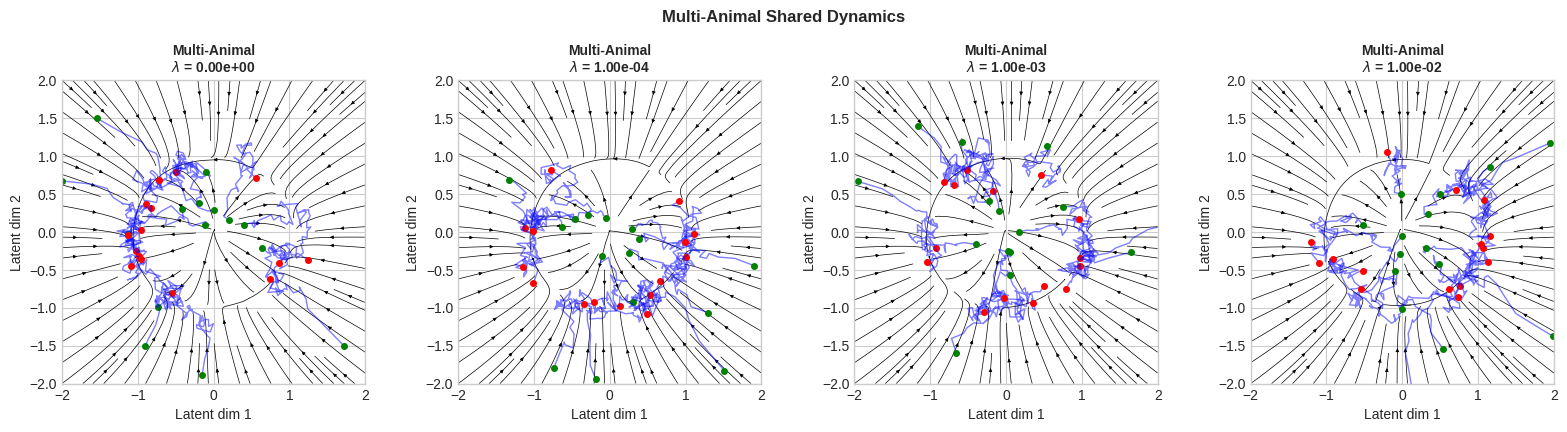

In [31]:
experiment = 'multi_animal'
multi_runs = get_completed_runs(experiment)
multi_runs = sorted(multi_runs, key=lambda x: float(x.split('lambda_')[-1]) if 'lambda_' in x else 0)

print(f"Multi-animal runs: {multi_runs}")

if multi_runs:
    n_plots = min(4, len(multi_runs))
    fig, axes = plt.subplots(1, n_plots, figsize=(4*n_plots, 4))
    if n_plots == 1:
        axes = [axes]
    
    for ax, run_name in zip(axes, multi_runs[:n_plots]):
        try:
            ssm, cfg = load_trained_model(experiment, run_name)
            lambda_str = run_name.split('lambda_')[-1] if 'lambda_' in run_name else '?'
            plot_2d_dynamics(ssm, title=f"Multi-Animal\n$\\lambda$ = {lambda_str}", ax=ax)
        except Exception as e:
            ax.text(0.5, 0.5, f"Error: {str(e)[:30]}", ha='center', va='center', 
                    transform=ax.transAxes, fontsize=8)
    
    plt.suptitle('Multi-Animal Shared Dynamics', fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'multi_animal_dynamics.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No multi-animal runs found")

## 7. Sphere SO(3) Experiment

3D dynamics with SO(3) rotation symmetry on the sphere.

Sphere SO(3) runs: ['so3_full_lambda_0.00e+00', 'so3_full_lambda_1.00e-04', 'so3_full_lambda_1.00e-03', 'so3_full_lambda_1.00e-02']


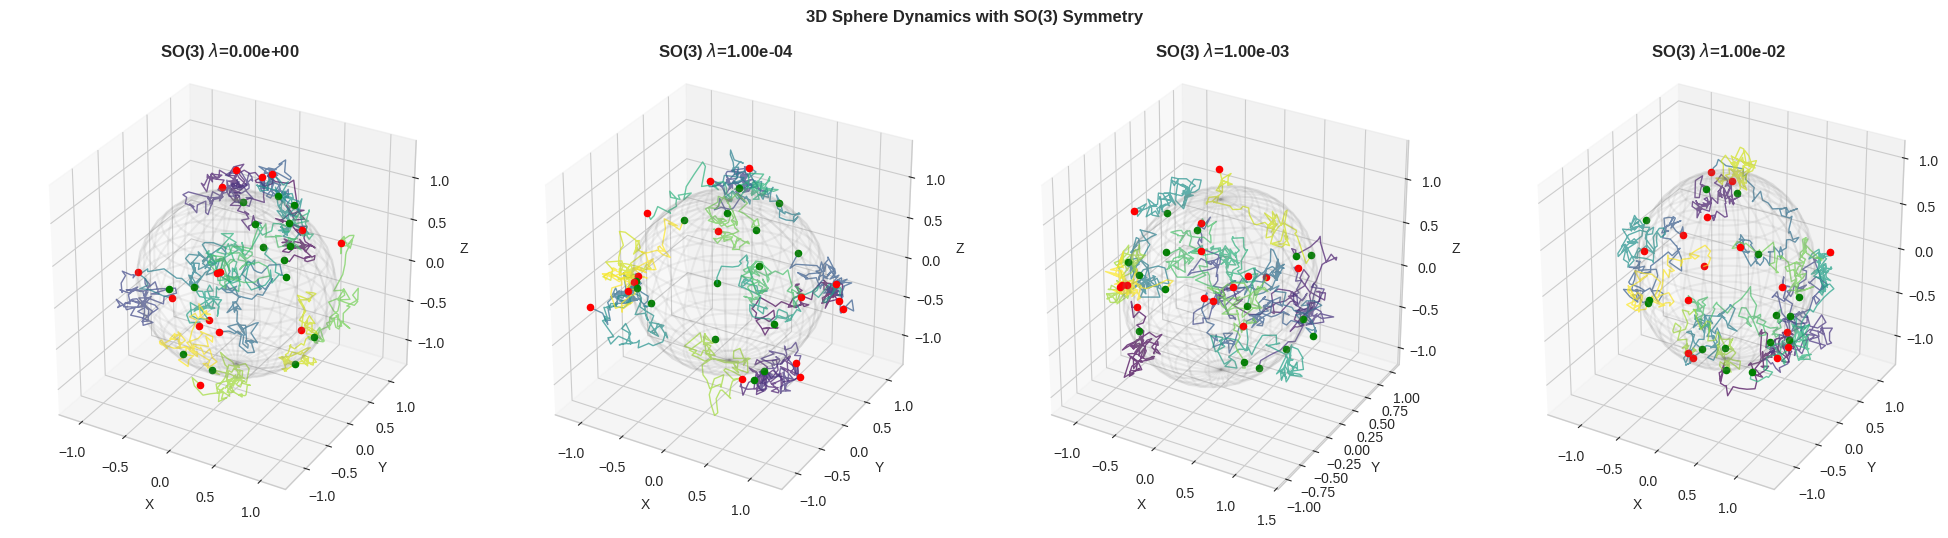

In [32]:
experiment = 'sphere_so3'
sphere_runs = get_completed_runs(experiment)
sphere_runs = sorted(sphere_runs, key=lambda x: float(x.split('lambda_')[-1]) if 'lambda_' in x else 0)

print(f"Sphere SO(3) runs: {sphere_runs}")

if sphere_runs:
    n_plots = min(4, len(sphere_runs))
    fig = plt.figure(figsize=(5*n_plots, 5))
    
    for i, run_name in enumerate(sphere_runs[:n_plots]):
        ax = fig.add_subplot(1, n_plots, i+1, projection='3d')
        try:
            ssm, cfg = load_trained_model(experiment, run_name, n_latents=3)
            lambda_str = run_name.split('lambda_')[-1] if 'lambda_' in run_name else '?'
            plot_3d_dynamics(ssm, title=f"SO(3) $\\lambda$={lambda_str}", ax=ax, n_trials=15, n_time=80)
        except Exception as e:
            ax.text2D(0.5, 0.5, f"Error: {str(e)[:30]}", ha='center', va='center', 
                      transform=ax.transAxes, fontsize=8)
    
    plt.suptitle('3D Sphere Dynamics with SO(3) Symmetry', fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'sphere_so3_dynamics.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No sphere SO(3) runs found")

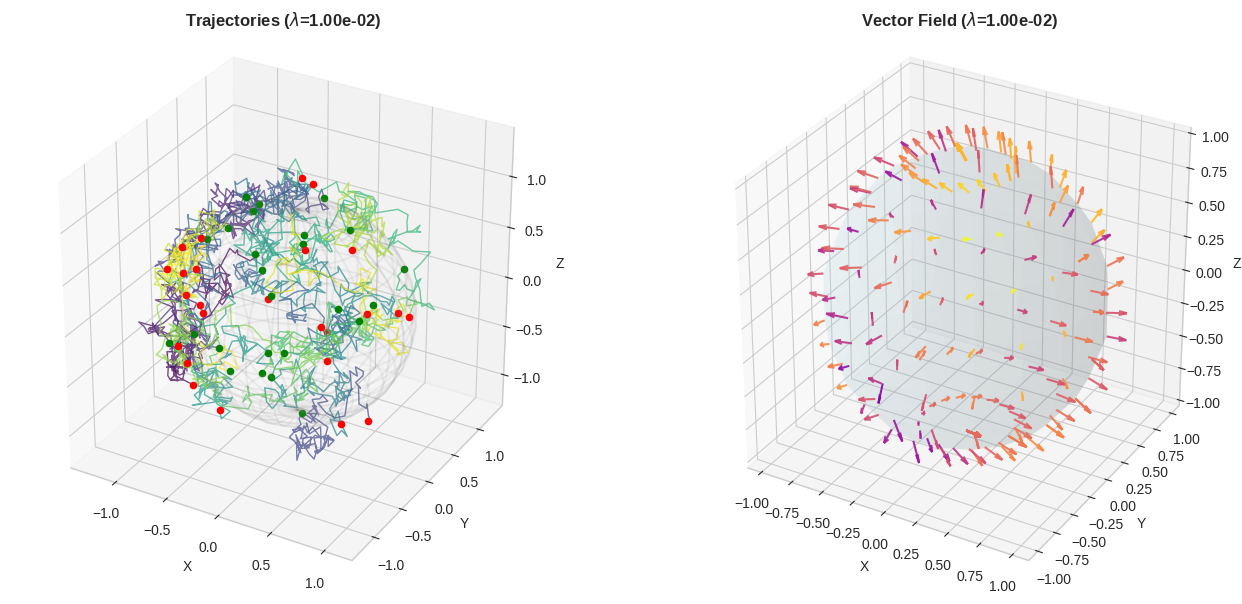

In [48]:
# Detailed view of best SO(3) model with vector field
if sphere_runs:
    fig = plt.figure(figsize=(14, 6))
    
    # Pick the run with highest lambda (usually most regularized)
    run_name = sphere_runs[-1]
    try:
        ssm, cfg = load_trained_model('sphere_so3', run_name, n_latents=3)
        lambda_str = run_name.split('lambda_')[-1]
        
        # Trajectories
        ax1 = fig.add_subplot(121, projection='3d')
        plot_3d_dynamics(ssm, title=f"Trajectories ($\\lambda$={lambda_str})", ax=ax1, n_trials=25, n_time=100)
        
        # Vector field
        ax2 = fig.add_subplot(122, projection='3d')
        plot_3d_vector_field(ssm, ax=ax2, n_pts=10)
        ax2.set_title(f"Vector Field ($\\lambda$={lambda_str})", fontweight='bold')
        
    except Exception as e:
        print(f"Error loading model: {e}")
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'sphere_so3_detailed.png', dpi=150, bbox_inches='tight')
    plt.show()

## 8. Training Curves & Quantitative Results

In [45]:
def plot_training_curves(experiment_name, runs=None, max_runs=8):
    """Plot training curves for an experiment."""
    if runs is None:
        runs = get_completed_runs(experiment_name)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for run_name in runs[:max_runs]:
        df = load_metrics_csv(experiment_name, run_name)
        if df is None:
            continue
        
        label = run_name.split('lambda_')[-1] if 'lambda_' in run_name else run_name[-15:]
        
        # if 'epoch' in df.columns:
        #     x = df['epoch']
        #     if 'valid_elbo' in df.columns:
        #         axes[0].plot(x, df['valid_elbo'], label=f'$\\lambda$={label}', alpha=0.8)
        #     if 'valid_lie' in df.columns:
        #         axes[1].plot(x, df['valid_lie'], label=f'$\\lambda$={label}', alpha=0.8)
        #     if 'valid_loss' in df.columns:
        #         axes[2].plot(x, df['valid_loss'], label=f'$\\lambda$={label}', alpha=0.8)

        if 'valid_elbo' in df.columns:
            df_valid = df.dropna(subset=['valid_elbo'])
            if len(df_valid) > 0:
                x = df_valid['epoch']
                axes[0].plot(x, df_valid['valid_elbo'], label=f'$\\lambda$={label}', alpha=0.8)
        if 'valid_lie' in df.columns:
            df_valid = df.dropna(subset=['valid_lie'])
            if len(df_valid) > 0:
                x = df_valid['epoch']
                axes[1].plot(x, df_valid['valid_lie'], label=f'$\\lambda$={label}', alpha=0.8)
        if 'valid_loss' in df.columns:
            df_valid = df.dropna(subset=['valid_loss'])
            if len(df_valid) > 0:
                x = df_valid['epoch']
                axes[2].plot(x, df_valid['valid_loss'], label=f'$\\lambda$={label}', alpha=0.8)
    
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Validation ELBO')
    axes[0].set_title('ELBO Loss')
    axes[0].legend(fontsize=7)
    
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Validation Lie Loss')
    axes[1].set_title('Lie Derivative Loss')
    axes[1].legend(fontsize=7)
    
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Validation Total Loss')
    axes[2].set_title('Total Loss')
    axes[2].legend(fontsize=7)
    
    plt.suptitle(f'{experiment_name} Training Curves', fontweight='bold')
    plt.tight_layout()
    return fig

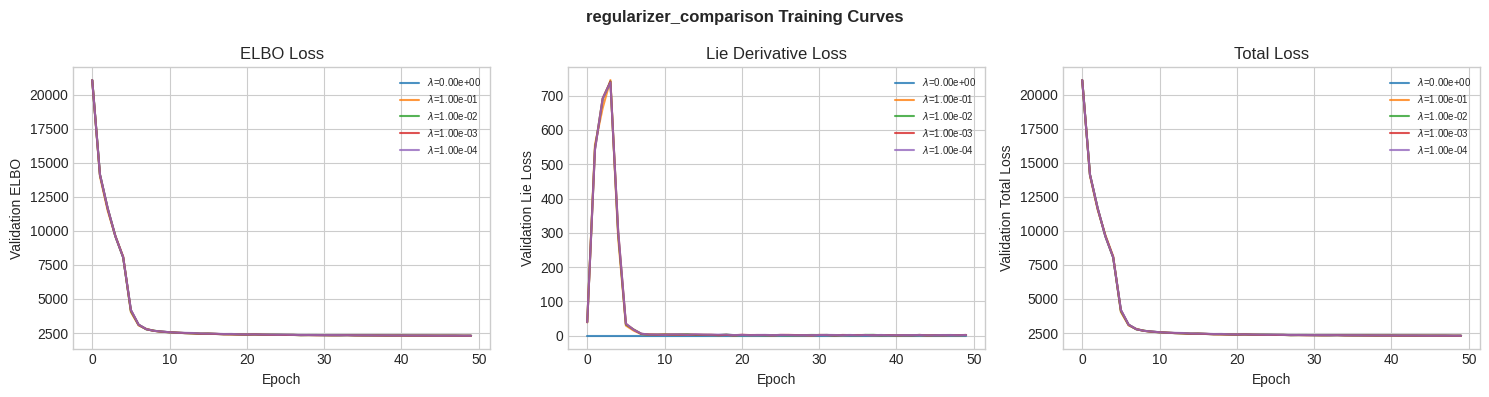

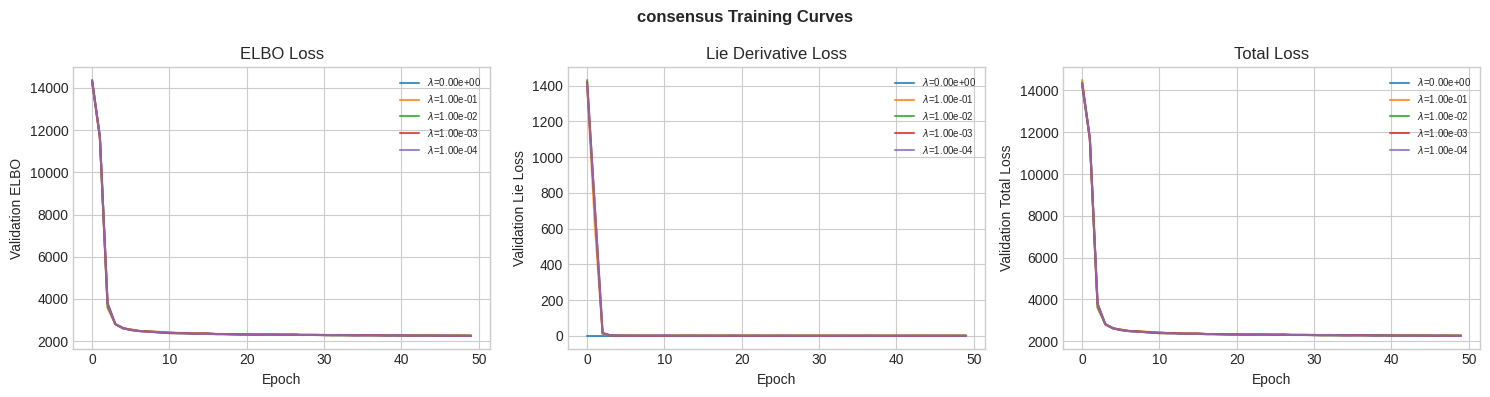

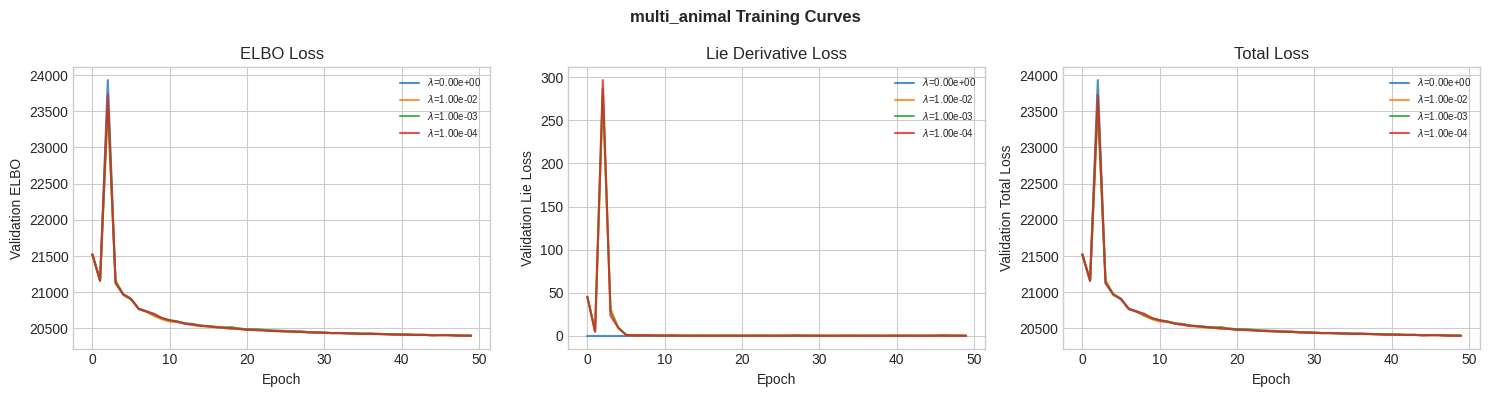

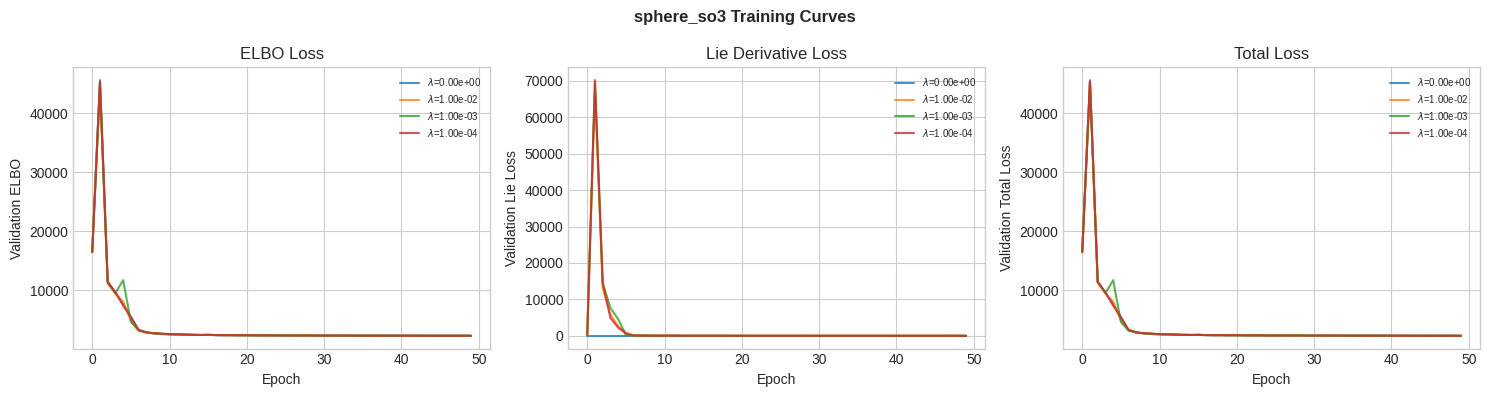

In [46]:
# Training curves for each experiment
for exp in ['regularizer_comparison', 'consensus', 'multi_animal', 'sphere_so3']:
    runs = get_completed_runs(exp)
    if runs:
        # Filter to rotation runs for regularizer_comparison
        if exp == 'regularizer_comparison':
            runs = [r for r in runs if 'lie_rotation' in r]
        fig = plot_training_curves(exp, runs)
        plt.savefig(FIGURES_DIR / f'{exp}_training_curves.png', dpi=150, bbox_inches='tight')
        plt.show()
    else:
        print(f"No runs for {exp}")

In [36]:
# Summary tables
print("=" * 80)
print("QUANTITATIVE RESULTS SUMMARY")
print("=" * 80)

for exp in ['regularizer_comparison', 'consensus', 'multi_animal', 'sphere_so3']:
    df = load_sweep_csv(exp)
    if df is not None:
        print(f"\n{exp.upper()}")
        print("-" * 60)
        cols = ['lambda_lie', 'final_elbo_loss', 'final_lie_loss', 'wall_time_s']
        if 'symmetry' in df.columns:
            cols = ['symmetry'] + cols
        display_cols = [c for c in cols if c in df.columns]
        print(df[display_cols].round(3).to_string(index=False))
    else:
        print(f"\n{exp}: No sweep results CSV found")

QUANTITATIVE RESULTS SUMMARY

regularizer_comparison: No sweep results CSV found

CONSENSUS
------------------------------------------------------------
    symmetry  lambda_lie  final_elbo_loss  final_lie_loss  wall_time_s
lie_rotation       0.000         2254.779           0.000     1620.410
lie_rotation       0.000         2253.888          12.835     1455.456
lie_rotation       0.001         2255.620          10.475     1461.806
lie_rotation       0.010         2257.418          13.744     1445.659
lie_rotation       0.100         2264.898          11.656     1432.760

MULTI_ANIMAL
------------------------------------------------------------
    symmetry  lambda_lie  final_elbo_loss  final_lie_loss  wall_time_s
lie_rotation       0.000        20402.914           0.000      798.664
lie_rotation       0.000        20398.584           1.160     1112.450
lie_rotation       0.001        20399.605           1.132     1059.446
lie_rotation       0.010        20399.580           1.668     

## 9. Pareto Frontier: ELBO vs Symmetry Loss

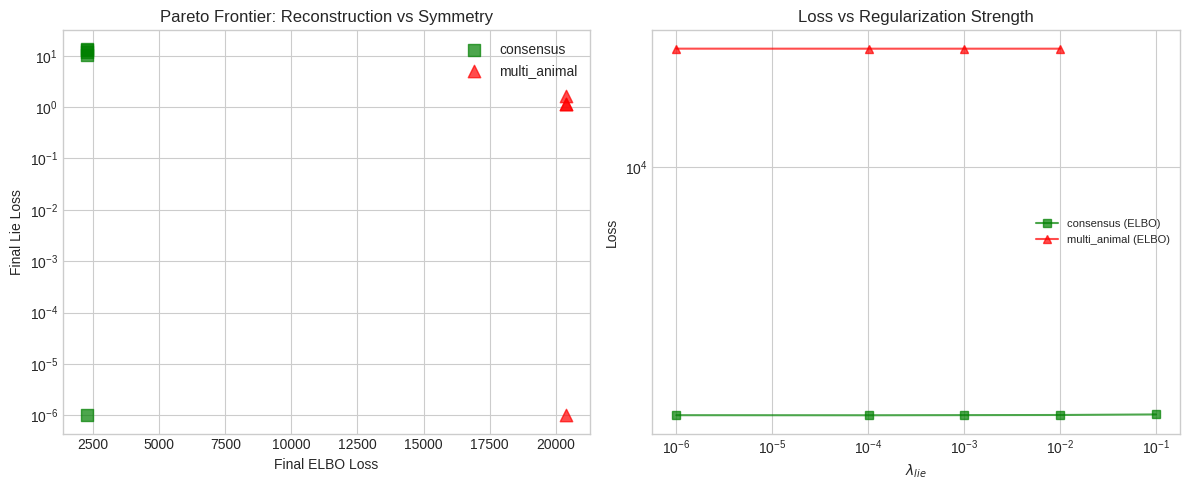

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Load all sweep results
for exp, marker, color in [
    ('regularizer_comparison', 'o', 'blue'),
    ('consensus', 's', 'green'),
    ('multi_animal', '^', 'red'),
    ('sphere_so3', 'd', 'purple')
]:
    df = load_sweep_csv(exp)
    if df is not None:
        # Filter to just rotation symmetry for regularizer_comparison
        if 'symmetry' in df.columns:
            df = df[df['symmetry'].str.contains('rotation', na=False)]
        
        if len(df) > 0:
            # ELBO vs Lie Loss
            axes[0].scatter(df['final_elbo_loss'], df['final_lie_loss'] + 1e-6, 
                           marker=marker, c=color, s=80, alpha=0.7, label=exp)
            
            # Lambda vs losses
            lambdas = df['lambda_lie'].values + 1e-6
            axes[1].loglog(lambdas, df['final_elbo_loss'], f'{marker}-', 
                          c=color, alpha=0.7, label=f'{exp} (ELBO)')

axes[0].set_xlabel('Final ELBO Loss')
axes[0].set_ylabel('Final Lie Loss')
axes[0].set_title('Pareto Frontier: Reconstruction vs Symmetry')
axes[0].legend()
axes[0].set_yscale('log')

axes[1].set_xlabel('$\\lambda_{lie}$')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss vs Regularization Strength')
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'pareto_frontier.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Summary

In [38]:
print(f"Figures saved to: {FIGURES_DIR}")
print("\nGenerated figures:")
for f in sorted(FIGURES_DIR.glob('*.png')):
    print(f"  - {f.name}")

Figures saved to: /orcd/data/manoli/001/om2/artliang/symm_reg/results/figures

Generated figures:
  - consensus_dynamics.png
  - consensus_training_curves.png
  - ground_truth_dynamics.png
  - multi_animal_dynamics.png
  - multi_animal_training_curves.png
  - pareto_frontier.png
  - regularizer_comparison_training_curves.png
  - rotation_lambda_comparison.png
  - sphere_so3_detailed.png
  - sphere_so3_dynamics.png
  - sphere_so3_training_curves.png
  - symmetry_type_comparison.png
